<a href="https://colab.research.google.com/github/MuhammadUsmanTahir10/BrainTumorDetector/blob/main/Brain_Tumour_Detection_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This project detects brain tumour by utilizing Deep Learning Models on Brain Tumour Dataset. Results of these models are analyzed to evaluate the validity of different models.**

**Imported Brain Tumour Dataset from Google Drive using Unmount Drive Option**

**Importing Libraries:**
*   For ML Models: Tensorflow, Keras
*   For Data Manipulation: numpy, pandas, sklearn
*   For Data Visualization: matplotlib, seaborn

In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

**Reading the Dataset:**

The code navigates through the training dataset directory using nested loops. The outer loop processes dataset paths, and the middle loop iterates over subdirectories (labels). The innermost loop iterates over images within each label's directory. For every image, the full path is constructed and added to the train_paths list, while the corresponding label is added to the train_labels list. This process collects file paths and labels for later use in machine learning tasks, such as image classification.

In [ ]:
# Path for train and test dataset
train_dataset = ['/content/drive/MyDrive/BrainTumourDetector/BrainTumourDataset/Training']
test_dataset = ['/content/drive/MyDrive/BrainTumourDetector/BrainTumourDataset/Testing']

train_paths = []
train_labels = []

for train_dir in train_dataset:
    for label in os.listdir(train_dir):
        for image in os.listdir(os.path.join(train_dir, label)):
            train_paths.append(os.path.join(train_dir, label, image))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []

for test_dir in test_dataset:
      for label in os.listdir(test_dir):
          for image in os.listdir(os.path.join(test_dir, label)):
              test_paths.append(os.path.join(test_dir, label, image))
              test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

**Plot No of Images as per category:**

Plotting train dataset

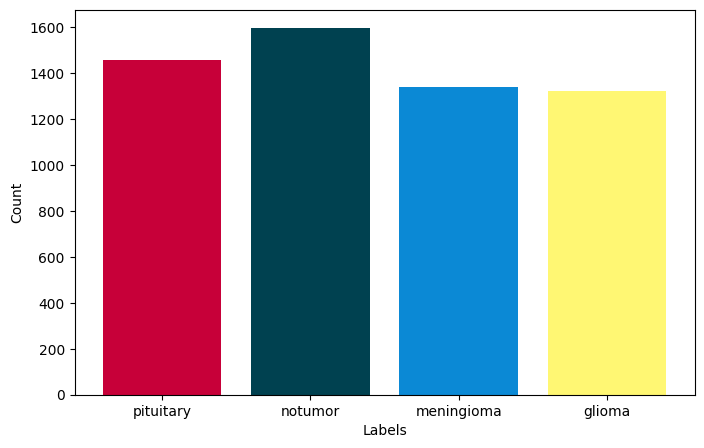

In [ ]:
plt.figure(figsize=(8,5))
colors = ['#C70039','#004150', '#0B89D5', '#FFF773']
labels = ['pituitary', 'notumor', 'meningioma', 'glioma']
counts = [len([x for x in train_labels if x == label]) for label in labels]
plt.bar(labels, counts, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

**Plot No of Images as per category:**

Plotting test dataset

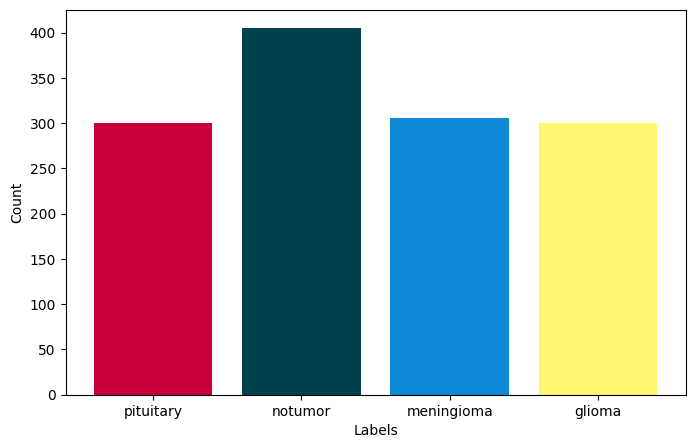

In [ ]:
plt.figure(figsize=(8,5))
colors = ['#C70039','#004150', '#0B89D5', '#FFF773']
labels = ['pituitary', 'notumor', 'meningioma', 'glioma']
counts = [len([x for x in test_labels if x == label]) for label in labels]
plt.bar(labels, counts, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

**Plotting Train vs Test Dataset:**

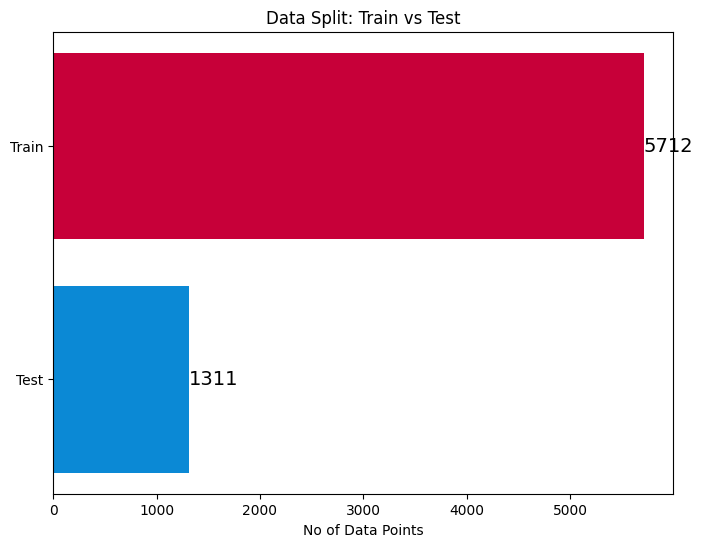

In [ ]:
# Data
labels = ['Train', 'Test']
data = [len(train_labels), len(test_labels)]
colors = ['#C70039', '#0B89D5']

# Horizontal Bar
plt.figure(figsize=(8, 6))
plt.barh(labels, data, color=colors)

# Add labels and values
for i in range(len(labels)):
  plt.text(data[i], labels[i], str(data[i]), va='center', fontsize=14, color='black')

# Set title and adjust layout
plt.title('Data Split: Train vs Test')
plt.xlabel('No of Data Points')
plt.gca().invert_yaxis()
plt.show()

**Data Augmentation:**
*   Random Brightness: 80% - 120%
*   Random Contrast: 80% - 120%

In [ ]:
from skimage import util

def augment_image(image):
  image = Image.fromarray(np.uint8(image))

  # Randomly adjust brightness and contrast
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))

  # Randomly rotate the image (up to 45 degrees)
  angle = random.uniform(-45, 45)
  image = image.rotate(angle)

  # Randomly flip the image horizontally
  if random.choice([True, False]):
    image = image.transpose(Image.FLIP_LEFT_RIGHT)

  # Add random noise to the image
  image = np.array(image) / 255.0
  image = util.random_noise(image, mode='gaussian', seed=None, clip=True)

  return image

**Plotting some sample images:**

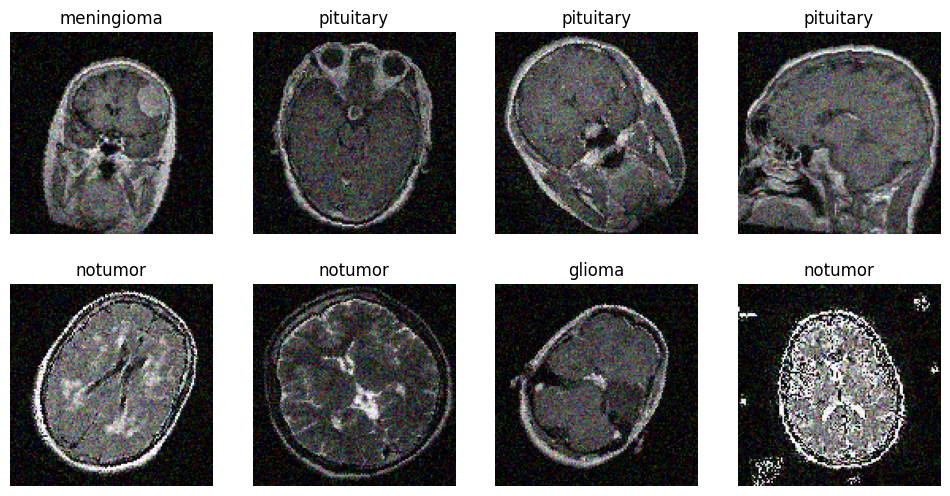

In [ ]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = [augment_image(load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))) for path in paths]
    return np.array(images)

# Select a subset of paths and labels for visualization
subset_paths = train_paths[50:59]
subset_labels = train_labels[50:59]

# Open and augment images
subset_images = open_images(subset_paths)

# Visualize the augmented images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, image, label in zip(axes.flatten(), subset_images, subset_labels):
    ax.axis('off')
    ax.set_title(label)
    ax.imshow(image)

plt.rcParams.update({'font.size': 12})
plt.show()

**Data Generation:**

This code defines a set of functions to handle encoding and decoding of labels, along with a data generator function for creating batches of images and their corresponding encoded labels during the training process. The unique_labels variable is created by extracting unique labels from the training directory. The encode_label function takes a list of labels and returns an array of their corresponding indices in the unique_labels list. The decode_label function performs the reverse operation, mapping encoded indices back to their original labels. The datagen function is a generator that yields batches of images and their encoded labels from given paths and labels. It uses a specified batch size and number of epochs for training. Additionally, it relies on an assumed open_images function, not provided in the given code, to load and augment images from paths. Overall, these functions facilitate the processing and encoding of labels for training a machine learning model on a dataset.

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

**Model:**

First Using VGG16 for Transfer Learning

This code initializes a pre-trained VGG16 model with weights from ImageNet, excluding its top layer, and then freezes all layers to make them non-trainable. Subsequently, it selectively unfreezes the last three layers of the VGG16 model. A new sequential model is created with an input layer matching the specified image size, followed by the modified VGG16 base model. The model includes a flattening layer, dropout layers with specified dropout rates, a densely connected layer with ReLU activation, another dropout layer, and a final densely connected layer with a softmax activation function, which corresponds to the number of unique labels in the dataset. This design serves as a transfer learning approach, leveraging the pre-trained VGG16 features while allowing fine-tuning of the last layers to adapt the model to a specific classification task.

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
  layer.trainable = False

# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))


58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128

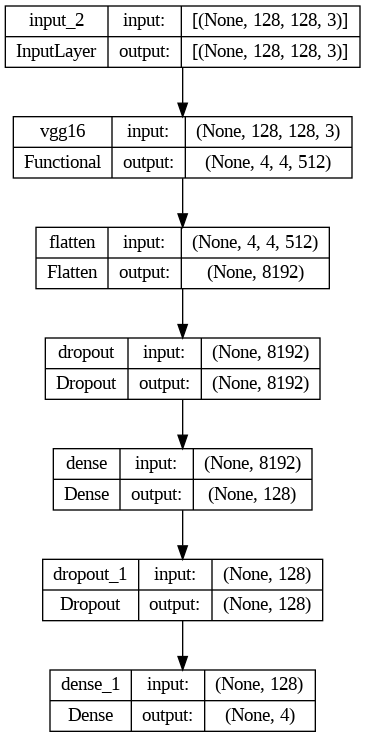

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

 Code below configures a neural network model for training using TensorFlow and Keras. The optimization is performed with the Adam optimizer, incorporating a learning rate of 0.0001. The chosen loss function is 'sparse_categorical_crossentropy,' suitable for multi-class classification tasks where each instance belongs to only one class. During training and evaluation, the model's performance is assessed using the 'sparse_categorical_accuracy' metric, which measures the accuracy of the model in predicting the correct class labels for the input data.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

**Train Model**

This code is part of a training process for a neural network using TensorFlow and Keras. It sets a batch size of 25, indicating the number of training samples processed in each iteration. The variable "steps" is computed to determine the number of iterations needed to complete one epoch, dividing the total training dataset size by the batch size. The model is trained for 10 epochs using a data generator, specified by the datagen function, which dynamically loads and augments training data to enhance model generalization. The training progress, including loss and accuracy metrics, is recorded in the history variable. Overall, this configuration allows for efficient training on large datasets, leveraging batch processing and on-the-fly data augmentation.

In [ ]:
batch_size = 25
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
116/228 [==============>...............] - ETA: 22:42 - loss: 0.7288 - sparse_categorical_accuracy: 0.7100

**Plotting Accuracy and Loss:**

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparese_categorical_accuracy'], 'g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

**Model Evaluation:**

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)


In [ ]:
print(classification_report(y_true, y_pred))